# AI Launch Lab Summer Cohort - Analyzing Engery Usage in Remote Communities


### QGIS Model start (TODO)

#### QGIS Graphical Modeler
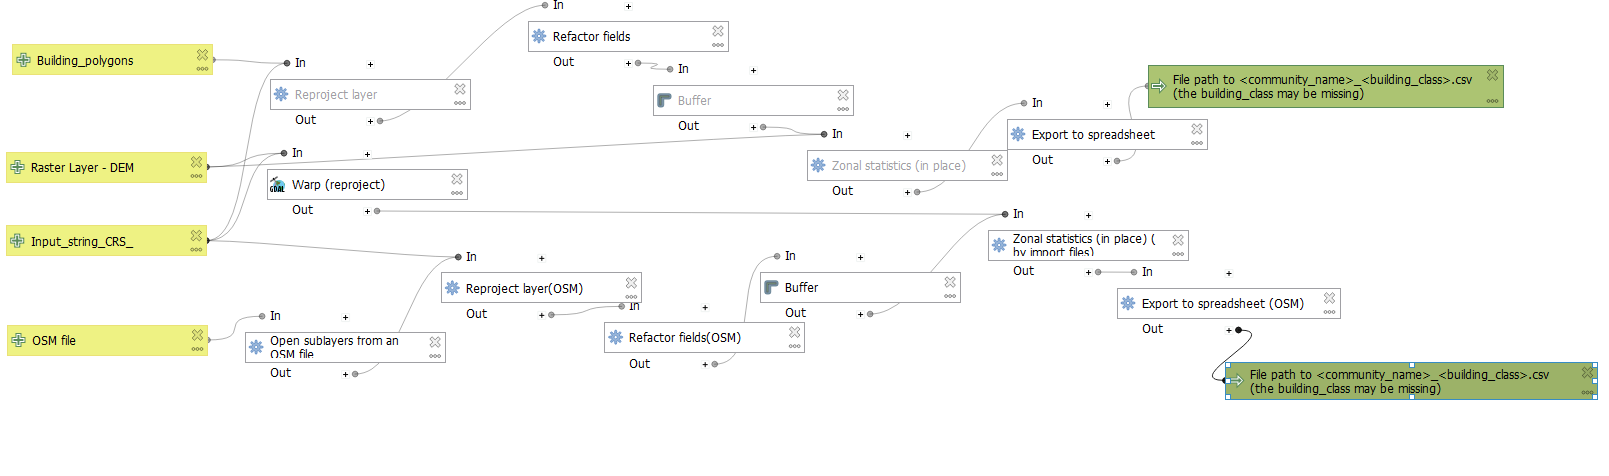





## Pipeline Setup, Dataset Creation, Data Cleansing

In [ ]:

# !pip install dtale 
# !pip install tensorflow_decision_forests 
!pip install tfx
# !pip install tensorflow_data_validation
# !pip install wurlitzer
# !pip install tensorflow-model-analysis


NOTE: You with have to press `RESTART RUNTIME` after running cell above

In [ ]:
import os
import pprint
import tempfile
import urllib
import sys
import math
import re
from collections import Counter

import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()


# Reproducable Pipeline
# import tfx
# from tfx.components import CsvExampleGen
# from tfx.components import ExampleValidator
# from tfx.components import SchemaGen
# from tfx.components import StatisticsGen
# from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
# from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input
# from tfx.components.transform.component import Transform

# import tensorflow_decision_forests as tfdf
# import tensorflow_model_analysis as tfma

# try:
#   from wurlitzer import sys_pipes
# except:
#   from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython import display
from IPython.display import Javascript
from google.colab import files
# from google.protobuf import text_format
from google.protobuf.json_format import MessageToDict

# print(f'TFX version: {tfx.__version__}')
print(f'Tensorflow version: {tf.__version__}')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Tensorflow version: 2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prior steps to use shared folders data without downloading or saving it elsewhere

1. Location `Remote Communities` in Google drive (should be in directory `Shared with me`)
2. Right click and choose `Add shortcut to Drive`
3. Open the `Files` on the left hand side of Colab
4. Press the third icon (mount drive). This will pop up a window and asking you to sign in to your Google account (or it will show you options of accounts if multiple). Choose the gmail where the `Remote Communities` was shared with you.

DONE.

If you have troubles with this you can run the cell below to mount your google drive instead. Click the link. Copy and paste the id in the the input box in colab.

### Locating google folder
1. Open the `Files` on the left hand side of Colab
2. Go into the `/content` directory 
3. Go into the `drive` directory
4. Go into the `MyDrive` directory
5. Go into the `Remote Communities` directory
6. Go into the `Datasets` 

NOTE: Linux shell using `%`

To get the current working directory `os.getcwd()`
We are going to save the current working directory as `cwd` and change the working directory to the location of the datasets shared with us.

In [ ]:
print(os.getcwd())

%cd drive/MyDrive/Remote Communities/Datasets

cwd = os.getcwd()
cwd

# Output should print path to /Datasets

/content
/content/drive/.shortcut-targets-by-id/1NpmNasbfRSPaSI3mcY4K6g8h6DeL3rOu/Remote Communities/Datasets


'/content/drive/.shortcut-targets-by-id/1NpmNasbfRSPaSI3mcY4K6g8h6DeL3rOu/Remote Communities/Datasets'

### Global Variables 

These global variables are meant to be changed manually for the user for different experiments or runs. 

If you wanted to change the response variable change `TARGET_COL = <name_of_col>`  where the `name_of_col` is the column from the dataset

If you wanted to change the explanatory variables change `FEATURE_COLS = [<name_of_col1>, ..., <name_of_coln>]`  where the `name_of_cols` are the features of interest.

**NOTE:** In python column names are lower case and does not include spaces but `_` instead

In [ ]:
# Target column (Y)
TARGET_COL = 'building_classification'

# columns (numeric) of interest #TODO: update with new columns
FEATURE_COLS = ['area', 'perimeter','perimeter_index','detour', 'width', 'length','exchange', 'exchange_index', 'range', 'range_index', 'pnt_count','fractal_dimensions','height_area', 'volume', 'building_height']
FEATURE_COLS_ORIGINAL = FEATURE_COLS.copy()

# For file input process
building_class_dict = {'com':'Commercial', 'ind':'Industrial', 'res':'Residential', 'unk':'Unknown'}

BALANCE_TRAINSET = False

#### Helper Functions

In [ ]:
def rename_df_cols(df):
    '''
    This function makes column names consistent and changes commun mistaks in cols
    '''

    # rename columns with all lowercase to python standard
    df.columns = [col.lower().strip() for col in df.columns ]


    # TODO: replace spaces with '_'

    # NOTE: THESE ARE HARD CODED COMMON MISTAKES

    # Change specific column names
    if 'shape_area' in df:
        df.rename(columns={'shape_area': 'area'}, inplace=True)
    if 'fractal dimensions' in df:
        df.rename(columns={'fractal dimensions': 'fractal_dimensions'}, inplace=True)
    if 'height area' in df:
        df.rename(columns={'height area': 'height_area'}, inplace=True)
    if 'building_h' in df:
        df.rename(columns={'building_h': 'building_height'}, inplace=True)
    if 'lengh' in df:
        df.rename(columns={'lengh': 'length'}, inplace=True)

    print(df.columns)
    return df

def get_file_name_info(file_name):
    '''Assuming file_name is <community_name>_<building_class_abrivation>.<file_type> '''
    list_ = re.split('[_.]', file_name)

    community_name = list_[0]
    building_class_value = ''
    if list_[1] in building_class_dict:
        building_class_value = building_class_dict[list_[1]]
    
    return community_name, building_class_value

def combine_func(row):
    '''Combines the columns of the join df by taking the non NaN
      NOTE: If more categorical vars are added, need to add an if case
      TODO: Fix ^ issue to be robust
    '''
    suffix = '_old'
    for col in cols:
        old_col = col + suffix
        if not col in drop_cols and old_col in cols:
            
            # if col == 'building_classification': # change this to string 

            #     # Check if NaN
            #     if isinstance(row[col], float) and math.isnan(row[col]): 
                    
            #         row[col] = row[col + suffix]
            
            if isinstance(row[col], float) and math.isnan(row[col]):
                row[col] = row[col + suffix]

        # This case is to fill manual data entry dataset (Cambridge Bay)
        if col == 'community_name' and isinstance(row[col], float) and math.isnan(row[col]):
                row[col] = 'cambridge bay'
        # This case is to fill blank building class with 'Unknown'
        if col == 'building_classification' and isinstance(row[col], float) and math.isnan(row[col]):
                row[col] = 'Unknown'
          
                 
    return row


    

### Setup Directories and Get Most Updated Dataset

In [ ]:
# Location of the pipeline metadata store
pipeline_path = os.path.join(cwd, 'pipeline')

# Directory of the image files
images_path = os.path.join(pipeline_path, 'images')

# Directory of the raw data files
data_path_raw = os.path.join(pipeline_path, 'data', 'raw')

# Directory of the processed data files
data_path_processed = os.path.join(pipeline_path, 'data', 'processed')

# Directory of the output GIS data files
gis_output_path = os.path.join(data_path_processed, 'gis output')

# Directory of the raw data osm files
data_osm_path = os.path.join(data_path_raw, 'osm files')

# Directory of the raw data osm files
data_qgis_output_path = os.path.join(data_path_raw, 'qgis output files')

# Path to a SQLite DB file to use as an MLMD storage.
# METADATA_PATH = os.path.join('metadata', , 'metadata.db')

# Output directory where created models from the pipeline will be exported.
# SERVING_MODEL_DIR = os.path.join('serving_model', pipeline_path)

# Create pipeline directory
if not os.path.isdir(pipeline_path):
    try:
        os.mkdir(pipeline_path)
    except OSError:
        print ("Creation of the directory %s failed" % pipeline_path)
    else:
        print ("Successfully created the directory %s " % pipeline_path)

# Create image directory
if not os.path.isdir(images_path):
    try:
        os.mkdir(images_path)
    except OSError:
        print ("Creation of the directory %s failed" % images_path)
    else:
        print ("Successfully created the directory %s " % images_path)

# RAW DATA -------------------------------------------------

# Create data raw directory
if not os.path.isdir(data_path_raw):
    try:
        os.mkdir(data_path_raw)
    except OSError:
        print ("Creation of the directory %s failed" % data_path_raw)
    else:
        print ("Successfully created the directory %s " % data_path_raw)

# Create data osm files directory
if not os.path.isdir(data_osm_path):
    try:
        os.mkdir(data_osm_path)
    except OSError:
        print ("Creation of the directory %s failed" % data_osm_path)
    else:
        print ("Successfully created the directory %s " % data_osm_path)

# Create data qgis output files directory
if not os.path.isdir(data_qgis_output_path):
    try:
        os.mkdir(data_qgis_output_path)
    except OSError:
        print ("Creation of the directory %s failed" % data_qgis_output_path)
    else:
        print ("Successfully created the directory %s " % data_qgis_output_path)
# ----------------------------------------------------------

def get_most_updated_dataset():
    # Create data processed directory
    if not os.path.isdir(data_path_processed):
        try:
            os.mkdir(data_path_processed)
        except OSError:
            print ("Creation of the directory %s failed" % data_path_processed)
        else:
            print ("Successfully created the directory %s " % data_path_processed)
        # Path of the raw original dataset (created by us) 
        #------TODO: if getting csv right from Google sheet => need google API
        dataset_name = "CBAY_footprints_enrich.csv" 
        dataset_relative_path = os.path.join(data_path_raw, dataset_name)

    else: # if processed folder is already created

        # get list of all csv files in "pipeline/data/raw/qgis output files"
        temp_file_list = [file_ for file_ in os.listdir( data_path_processed ) if os.path.isfile(os.path.join(data_path_processed, file_)) and file_.endswith('csv')]
        temp_file_list = sorted(temp_file_list, key=lambda t: -os.stat(os.path.join(data_path_processed,t)).st_mtime)
        
        # if processed folder is not empty
        if len(temp_file_list) > 0:

            print(temp_file_list[0])
            dataset_name = temp_file_list[0]
            dataset_relative_path = os.path.join(data_path_processed, dataset_name)

    # Create data gis output files directory
    if not os.path.isdir(gis_output_path):
        try:
            os.mkdir(gis_output_path)
        except OSError:
            print ("Creation of the directory %s failed" % gis_output_path)
        else:
            print ("Successfully created the directory %s " % gis_output_path)


    # Get Original (most up-to-date) dataset
    return pd.read_csv(dataset_relative_path, index_col='osm_way_id') 

# Get Original (most up-to-date) dataset    
df = get_most_updated_dataset()

# Rename dataframe columns 
df = rename_df_cols(df)
df.head

building_footprints_dataset_14_08_2021_13_48.csv
Index(['centroid_x', 'centroid_y', 'area', 'perimeter', 'perimeter_index',
       'detour', 'width', 'length', 'pnt_count', 'exchange', 'exchange_index',
       'range', 'range_index', 'min', 'max', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_height',
       'height_area', 'volume', 'length_width', 'building_type'],
      dtype='object')


<bound method NDFrame.head of               centroid_x   centroid_y  ...  length_width            building_type
osm_way_id                             ...                                       
146311312.0  236375.9673  458215.5240  ...      1.161814               Commercial
146311316.0  236330.6174  458523.3054  ...      0.755975   Multi-Unit Residential
146311319.0  236243.3362  458305.5581  ...      1.329119               Commercial
146311320.0  236753.9965  458352.1783  ...      0.757841  Single-Unit Residential
146311322.0  235993.5425  458208.1908  ...      0.292651               Commercial
...                  ...          ...  ...           ...                      ...
905192470.0  609407.2785  466556.6204  ...      0.444339                      NaN
905192474.0  609335.5637  466370.9443  ...      0.397326                      NaN
905192475.0  609230.6814  466537.9144  ...      0.330325                      NaN
905192476.0  609280.5204  466532.8019  ...      0.422600            

### Get new datasets, Feature Engineer, Combine new datasets

NOTE: Skip this section if you are not changing dataset 

TODO: Consider either romve or move files after processed 

In [ ]:
# get list of all files in "pipeline/data/raw/qgis output files"
file_list = os.listdir( data_qgis_output_path )

# Creat new dataframe
df_new = pd.DataFrame()
for file_ in file_list: # file is a string not file type

    # If .csv file
    if file_.endswith('.csv'): 

        # Get next file in directory
        path = os.path.join(data_qgis_output_path, file_)
        df_file = pd.read_csv(path)
        
        # Remove any non-buildings
        df_file.dropna(subset=['osm_way_id'], inplace=True)

        # Set index as 'osm_way_id
        df_file.set_index(keys='osm_way_id', inplace=True)

        # parse file name to get features
        community_name, building_class_value = get_file_name_info(file_)

        # Create a building classification column (for model)
        if building_class_value in building_class_dict.values():
            df_file['building_classification'] = building_class_value

        # Create a community name column (for human readability)
        df_file['community_name'] = community_name

        # Change column names from QGIS model: NOTE: this could be done in QGIS
        if '_min:double precision(0,0)' in df_file:
            df_file.rename(columns={'_min:double precision(0,0)': 'min'}, inplace=True)
        if '_max:double precision(0,0)' in df_file:
            df_file.rename(columns={'_max:double precision(0,0)': 'max'}, inplace=True)
        if 'lengh' in df:
            df.rename(columns={'lengh': 'length'}, inplace=True)

        # Add new df to new temporary df
        df_new = df_new.append(df_file)

# Feature Engineering 
if 'area' in df_new and 'perimeter' in df_new:
    df_new['fractal_dimensions'] = df_new['area'] / df_new['perimeter']
if 'min' in df_new and 'max' in df_new:
    df_new['building_height'] = df_new['max'] - df_new['min']
if 'building_height' in df_new and 'area' in df_new:
  df_new['height_area'] = df_new['building_height'] / df_new['area']
  df_new['volume'] = df_new['building_height'] * df_new['area']

if 'width' in df_new and 'length' in df_new:
    df_new['length_width'] = df_new['length'] / df_new['width']


# display new dataframe
df_new

,centroid_x,centroid_y,area,perimeter,perimeter_index,detour,width,length,pnt_count,exchange,exchange_index,range,range_index,min,max,building_classification,community_name,fractal_dimensions,building_height,height_area,volume,length_width
osm_way_id,,,,,,,,,,,,,,,,,,,,,,
422205377.0,1.869581e+06,816528.493810,92237.364088,2298.483057,2.137639,2157.648503,435.265169,952.904283,17.0,38418.354727,0.416516,1008.639510,0.679520,4.015660,29.012119,Commercial,pangnirtung,40.129669,24.996459,0.000271,2.305607e+06,2.189250
516426702.0,1.869727e+06,816604.154152,312.239898,84.839035,1.356119,77.391899,21.911177,29.768980,11.0,221.417224,0.709125,30.105864,1.324580,25.248236,29.930019,Commercial,pangnirtung,3.680380,4.681784,0.014994,1.461840e+03,1.358621
516426703.0,1.869728e+06,816572.789779,18.904419,17.811012,1.157053,17.759036,5.623510,5.235114,6.0,16.226198,0.858328,6.623803,1.481356,26.279087,27.944654,Commercial,pangnirtung,1.061389,1.665567,0.088105,3.148658e+01,0.930934
516426704.0,1.869742e+06,816577.922370,34.055579,23.831676,1.153472,23.831676,5.790152,7.444327,5.0,28.374976,0.833196,8.789167,1.498413,26.940308,29.756895,Commercial,pangnirtung,1.429005,2.816587,0.082706,9.592052e+01,1.285688
516426705.0,1.869734e+06,816575.228760,26.444291,20.872135,1.146429,20.872135,6.896232,5.535035,5.0,22.483091,0.850206,7.472665,1.553015,26.418800,28.906113,Commercial,pangnirtung,1.266966,2.487312,0.094059,6.577521e+01,0.802617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762047309.0,2.357637e+05,458831.493600,234.095960,64.030949,1.182060,64.030949,12.970819,21.897062,5.0,179.688478,0.767585,23.814991,1.449878,13.785145,14.791609,NaN,cambridge bay,3.655981,1.006464,0.004299,2.356092e+02,1.688179
762047310.0,2.357997e+05,458821.365700,155.589653,50.377602,1.140758,50.377602,11.950503,15.481484,5.0,135.692649,0.872119,18.219230,1.545060,14.620831,15.566196,NaN,cambridge bay,3.088469,0.945366,0.006076,1.470892e+02,1.295467
762047311.0,2.358284e+05,458823.011200,181.082216,55.046584,1.155417,55.046584,12.186403,17.602782,5.0,149.301333,0.824495,19.946716,1.522480,13.609070,15.570609,NaN,cambridge bay,3.289618,1.961539,0.010832,3.551999e+02,1.444461


Join new dataset with old dataset to add new data instances and update old instances

In [ ]:
print(df.columns)
print(df_new.columns)

Index(['centroid_x', 'centroid_y', 'area', 'perimeter', 'perimeter_index',
       'detour', 'width', 'length', 'pnt_count', 'exchange', 'exchange_index',
       'range', 'range_index', 'min', 'max', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_height',
       'height_area', 'volume', 'length_width', 'building_type', 'predicted',
       'actual', 'status'],
      dtype='object')
Index(['centroid_x', 'centroid_y', 'area', 'perimeter', 'perimeter_index',
       'detour', 'width', 'length', 'pnt_count', 'exchange', 'exchange_index',
       'range', 'range_index', 'min', 'max', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_height',
       'height_area', 'volume', 'length_width'],
      dtype='object')


In [ ]:
# Common instances
df_join = df_new.join(df, how='outer', lsuffix='', rsuffix='_old')

drop_cols = [col for col in df_join.columns if col.endswith('_old') ]
cols = df_join.columns

  

df_join = df_join.apply(combine_func, axis='columns')

# df_join.reset_index(inplace=True)

df_join.drop(drop_cols, axis='columns', inplace=True)

df_join.reset_index(inplace=True)
df_join.drop_duplicates(subset=['osm_way_id'], inplace=True)

df_join.set_index(keys=['osm_way_id'], inplace=True)


df_join

,centroid_x,centroid_y,area,perimeter,perimeter_index,detour,width,length,pnt_count,exchange,exchange_index,range,range_index,min,max,building_classification,community_name,fractal_dimensions,building_height,height_area,volume,length_width,building_type,predicted,actual,status
osm_way_id,,,,,,,,,,,,,,,,,,,,,,,,,,
146311312.0,236375.9673,458215.5240,1358.082946,154.165029,1.181596,147.327370,44.596852,51.813265,9.0,1159.061592,0.853454,52.467245,1.585112,15.801981,27.640675,0,cambridge bay,8.809280,11.838694,0.008717,16077.927908,1.161814,Commercial,Commercial,Commercial,Correct
146311316.0,236330.6174,458523.3054,463.591172,87.969683,1.154016,87.969683,29.283676,22.137738,5.0,383.796205,0.827876,31.669104,1.534323,16.852879,21.869761,2,cambridge bay,5.269897,5.016882,0.010822,2325.782178,0.755975,Multi-Unit Residential,Industrial,Residential,Incorrect
146311319.0,236243.3362,458305.5581,1221.919762,149.322080,1.206561,149.322080,42.425538,56.388607,8.0,889.510048,0.727961,56.263942,1.402091,15.352618,23.766201,0,cambridge bay,8.183115,8.413583,0.006886,10280.723093,1.329119,Commercial,Commercial,Commercial,Correct
146311320.0,236753.9965,458352.1783,115.094977,44.710700,1.177144,44.710700,16.198747,12.276077,5.0,89.339732,0.776226,16.412462,1.475161,10.602724,13.283726,2,cambridge bay,2.574216,2.681002,0.023294,308.569824,0.757841,Single-Unit Residential,Residential,Residential,Correct
146311322.0,235993.5425,458208.1908,669.116281,151.280944,1.651885,145.292670,61.574825,18.019949,7.0,293.772362,0.439045,61.846853,0.943883,8.738390,17.486572,0,cambridge bay,4.423004,8.748182,0.013074,5853.551207,0.292651,Commercial,Residential,Commercial,Incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905192470.0,609407.2785,466556.6204,423.804552,98.991302,1.358190,98.991302,39.904063,17.730913,5.0,245.368193,0.578965,40.025919,1.160718,30.069035,31.984863,Residential,gjoa haven,4.281230,1.915829,0.004521,811.936924,0.444339,0,NaN,NaN,NaN
905192474.0,609335.5637,466370.9443,425.965472,104.117947,1.424901,104.117947,43.013096,17.090220,5.0,228.422054,0.536245,43.004907,1.083064,25.452986,29.883318,Residential,gjoa haven,4.091182,4.430332,0.010401,1887.168542,0.397326,0,NaN,NaN,NaN
905192475.0,609230.6814,466537.9144,472.433857,102.343853,1.329957,102.343853,39.676267,13.106080,5.0,283.386715,0.599844,41.060078,1.194637,33.004990,35.847733,Residential,gjoa haven,4.616143,2.842743,0.006017,1343.008002,0.330325,0,NaN,NaN,NaN


In [ ]:
df_join['building_classification'].value_counts(dropna=False)

2              416
Residential    388
Industrial     115
3              110
Commercial     108
0               86
1               74
Name: building_classification, dtype: int64

This is a last check before you save dataset if all columns of interest are included

In [ ]:
df_join.columns

Index(['centroid_x', 'centroid_y', 'area', 'perimeter', 'perimeter_index',
       'detour', 'width', 'length', 'pnt_count', 'exchange', 'exchange_index',
       'range', 'range_index', 'min', 'max', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_height',
       'height_area', 'volume', 'length_width', 'building_type', 'predicted',
       'actual', 'status'],
      dtype='object')

Save new dataset

In [ ]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
 
# dd_mm_YY_H_M
# NOTE: This is UTC - 0 time zone
dt_string = "building_footprints_dataset_" + now.strftime("%d_%m_%Y_%H_%M") + ".csv"

df_join.to_csv(os.path.join(data_path_processed, dt_string))

## Using Tensorflow-Extended

#### Create the InteractiveContext

In [ ]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=pipeline_path)

#### ExampleGen

You will then ingest the data from the dataframe you defined earlier. You may want to remove notebook checkpoints in case you get an error about different headers.

In [ ]:
# Run CSV ExampleGen
example_gen = CsvExampleGen(input_base=data_path)  
context.run(example_gen)

RuntimeError: ignored

### StatisticsGen

Next, you will generate the statistics that will be used by the next components. Feel free to also explore it when you run `context.show()`.

In [ ]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])

# Execute the component
context.run(statistics_gen)

# Show the output statistics
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

You will now infer the schema based on the statistics artifact. For the version of TFX you are using, you will have to explicitly set `infer_feature_shape=True` so the downstream TFX components (e.g. Transform) will parse input as a `Tensor` and not `SparseTensor`. If not set, you will have compatibility issues later when you run the transform.

In [ ]:
# Instantiate SchemaGen with the StatisticsGen ingested dataset
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'], 
    infer_feature_shape=True
    )

# Run the component
context.run(schema_gen)

# Visualize the schema
context.show(schema_gen.outputs['schema'])

TODO: restrict the domain (e.g. numeric range) so you can avoid invalid data from going into your training set.

### ExampleValidator

In [ ]:
# Instantiate ExampleValidator with the StatisticsGen and SchemaGen ingested data
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

# Run the component.
context.run(example_validator)

# Visualize the results
context.show(example_validator.outputs['anomalies'])

NameError: ignored

Remove the blanks 
- TODO: possibility use blanks as test or semi-supervised

In [ ]:
print(df[TARGET_COL].value_counts(dropna=False), '\n')

# Drop the rows with blanks in TARGET_COL #TODO: this might be needed for the future
df.dropna(subset=[TARGET_COL], inplace=True)

# To test removal
df[TARGET_COL].value_counts(dropna=False)

Single-Unit Residential    288
Multi-Unit Residential      95
Industrial                  72
Commercial                  72
Garage                      40
Unknown                     29
Name: building_type, dtype: int64 



Single-Unit Residential    288
Multi-Unit Residential      95
Industrial                  72
Commercial                  72
Garage                      40
Unknown                     29
Name: building_type, dtype: int64

## Explanatory Data Analysis (EDA)

In [ ]:
#Buildings by Communities
pd.crosstab(df['community_name'], df[TARGET_COL])

building_classification,Commercial,Industrial,Residential,Unknown
community_name,,,,
arviat,18,15,74,0
baker lake,34,34,94,0
bakerlake,34,34,94,0
cambridge bay,86,74,416,110
clyde river,5,18,40,0
coral harbour,9,4,21,0
gjoa haven,2,13,37,0
igloolik,26,8,50,0
kugluktuk,4,15,51,0


In [ ]:
# drop Unknown classification

# TODO: Combine these statements
df_eda=df[df[TARGET_COL]!="Unknown"]

print("Communities: \n\n", df_eda['community_name'].value_counts())

df_cambridge=df_eda[df_eda['community_name']=="cambridge bay"]
print("size of the dataset:",df_eda.shape)

Communities: 

 cambridge bay    576
baker lake       162
bakerlake        162
arviat           107
igloolik          84
pangnirtung       78
kugluktuk         70
clyde river       63
gjoa haven        52
pond inlet        42
coral harbour     34
Name: community_name, dtype: int64
size of the dataset: (1430, 27)


What does below do? (TODO)

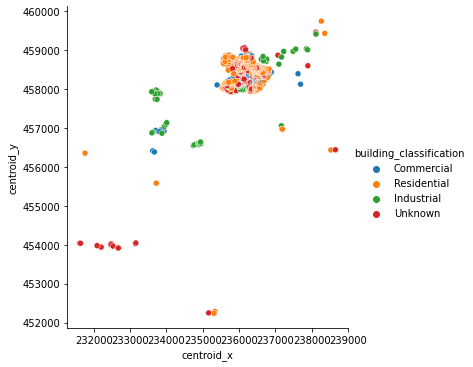

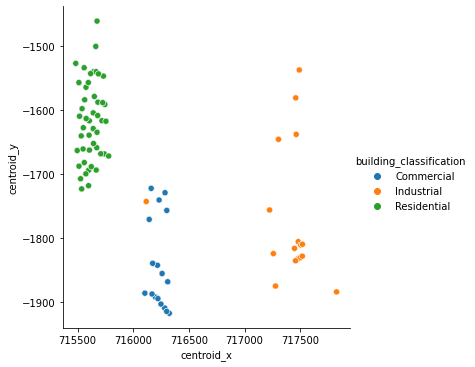

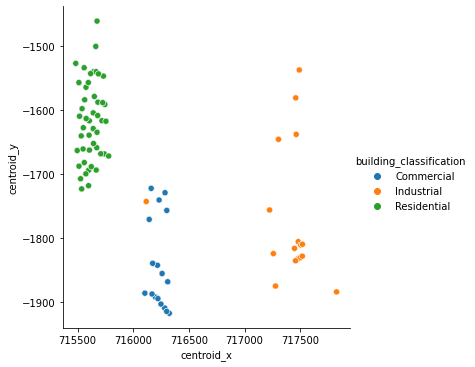

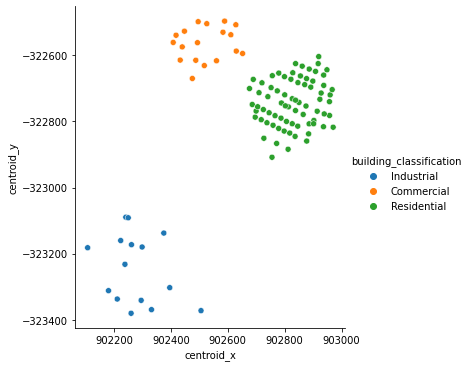

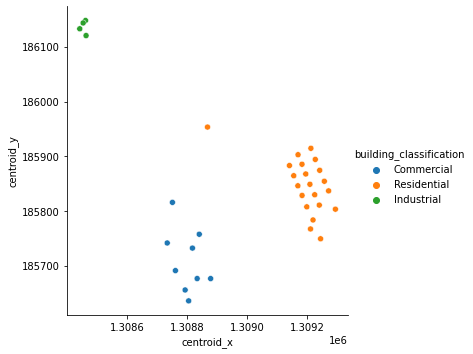

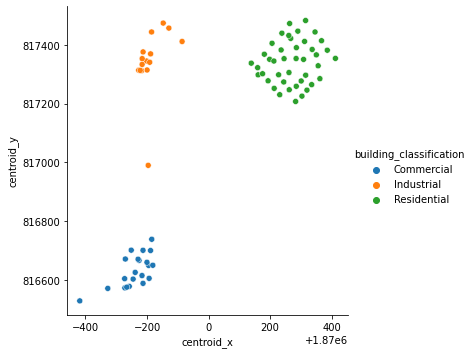

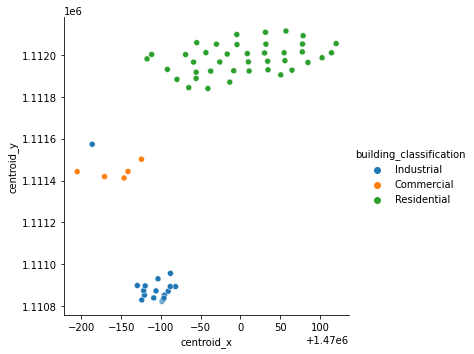

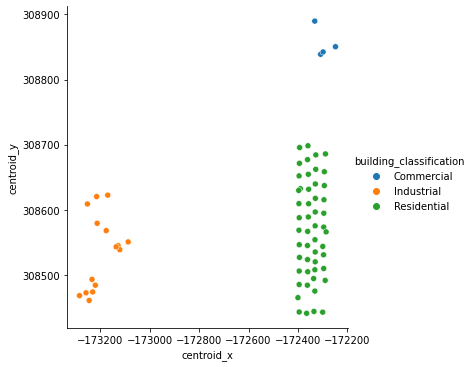

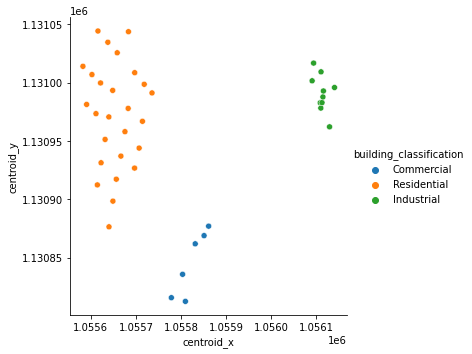

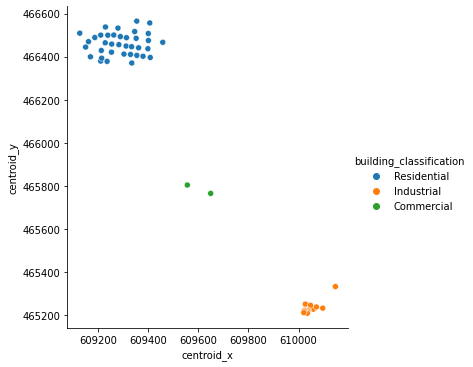

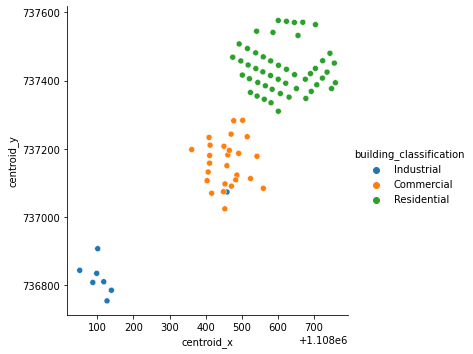

In [ ]:
# Buildings by Remote Communities and classification
for i in list(df['community_name'].unique()):
  sns.relplot(x='centroid_x', y='centroid_y', data=df[df['community_name']==i], kind="scatter",hue=TARGET_COL)

Look at the missing data. A map that visualizes missing data

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

In [ ]:
df[FEATURE_COLS + [TARGET_COL]].groupby([TARGET_COL]).describe()

KeyError: ignored

In [ ]:
#Summary statistics for category colums
pd.crosstab(df['building_classification'], df['building_type'])

building_type,Commercial,Garage,Industrial,Multi-Unit Residential,Single-Unit Residential,Unknown
building_classification,,,,,,
Commercial,72,12,0,0,2,0
Industrial,0,2,72,0,0,0
Residential,0,26,0,95,286,9


Boxplot by building_classification

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

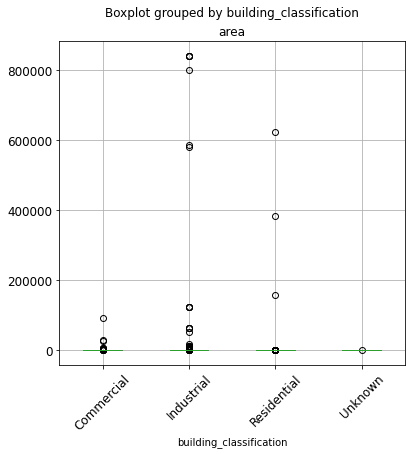

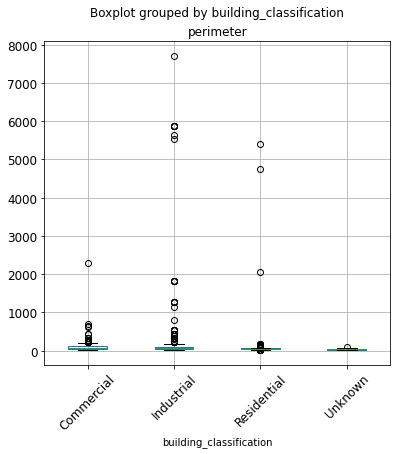

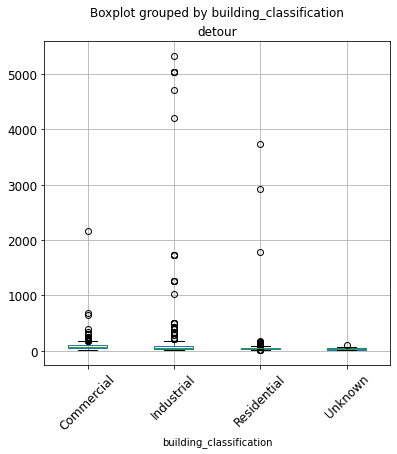

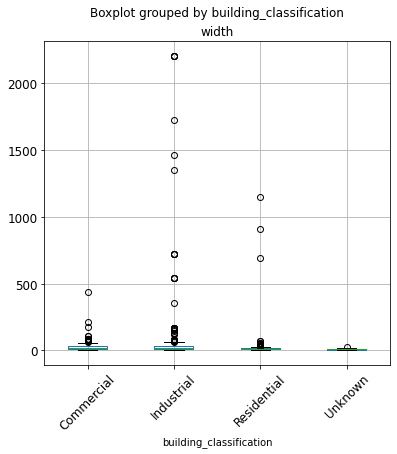

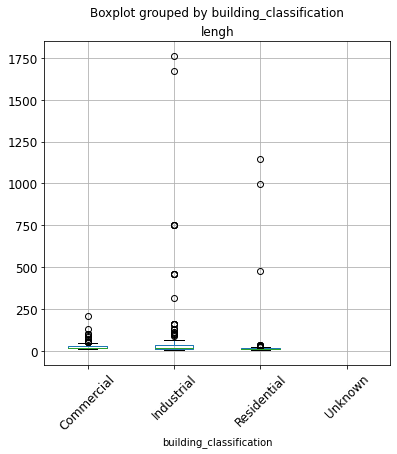

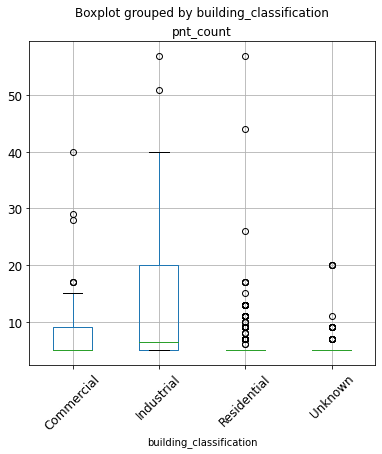

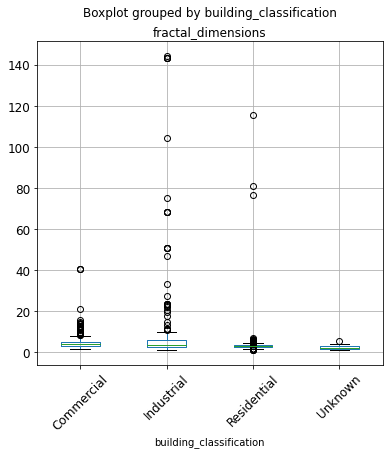

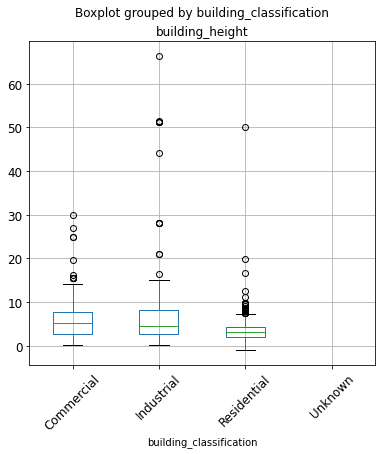

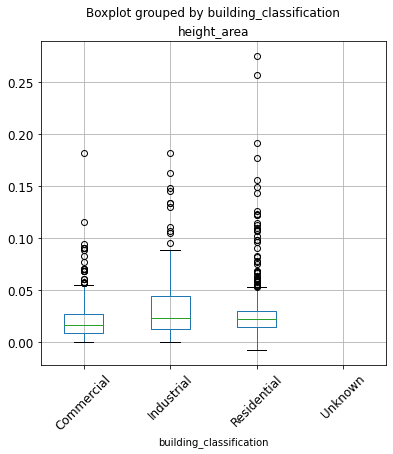

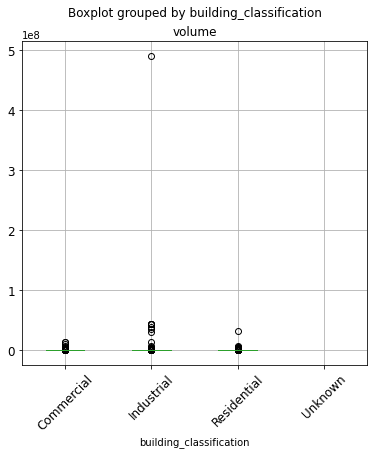

In [ ]:
df.boxplot(column=['area'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['perimeter'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['detour'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['width'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['lengh'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['pnt_count'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['fractal_dimensions'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['building_height'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['height_area'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))
df.boxplot(column=['volume'],by=TARGET_COL,rot=45, fontsize=12, figsize=(6,6))

<Figure size 2160x2160 with 0 Axes>

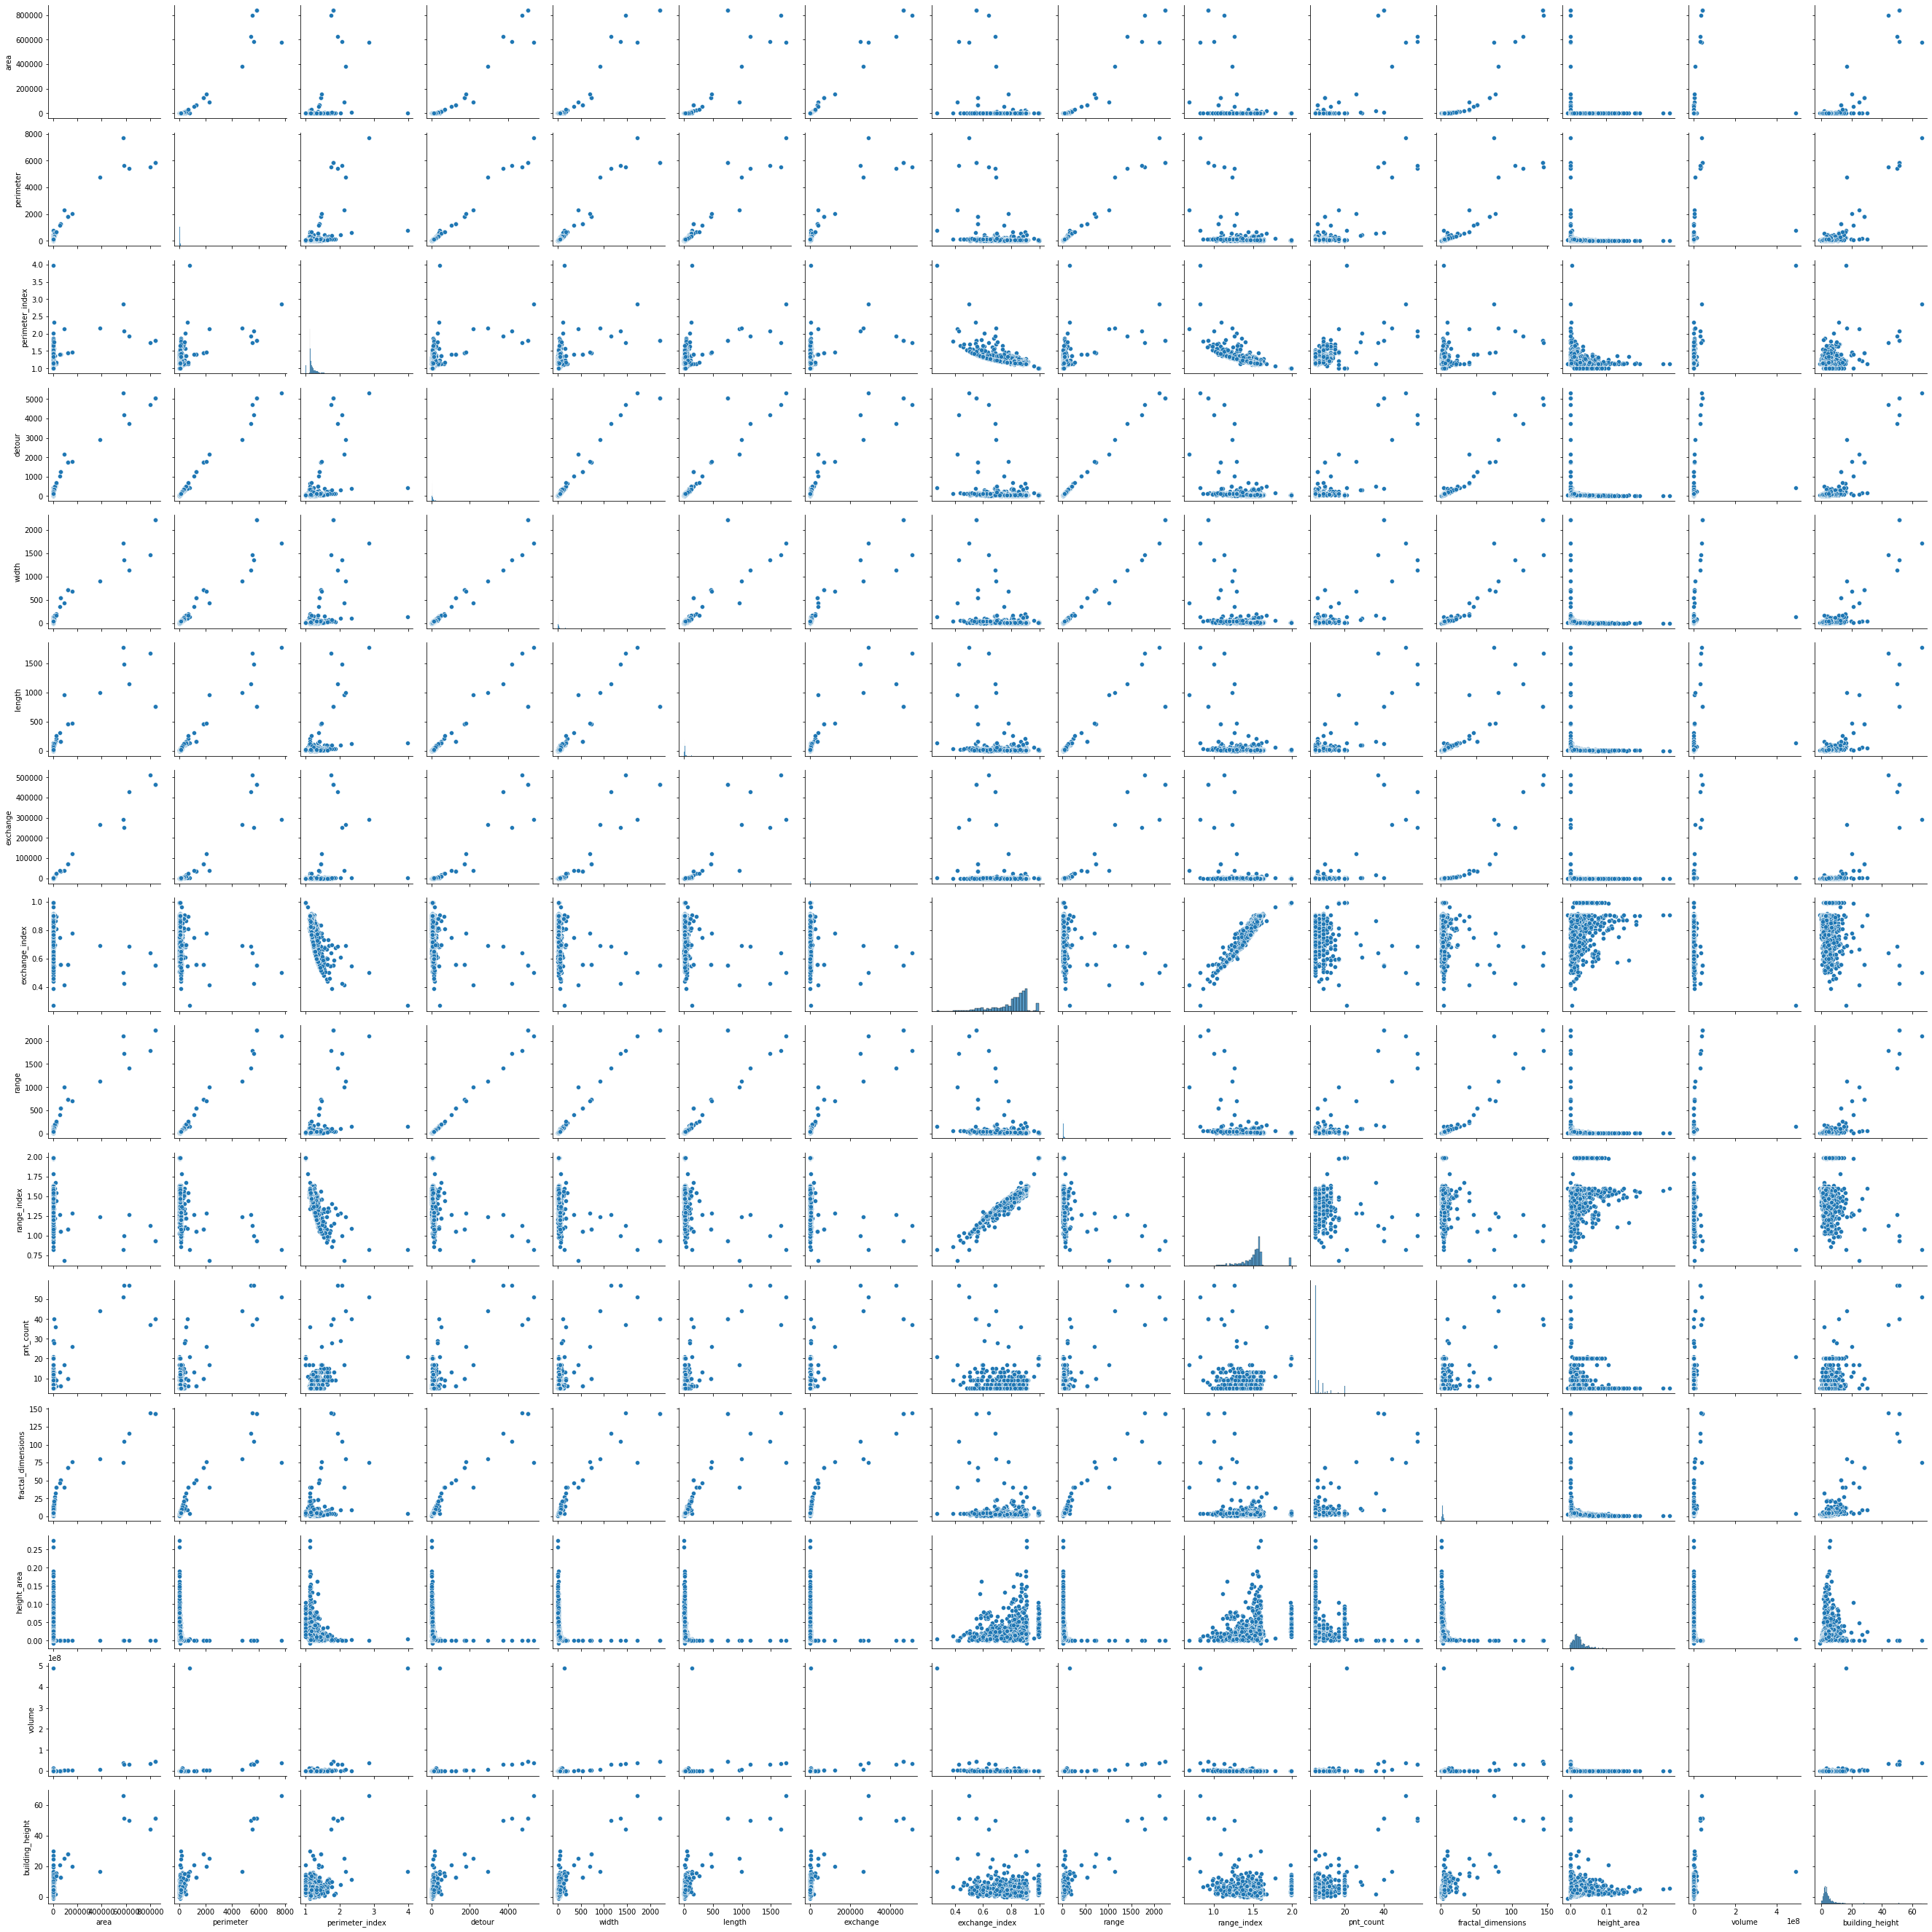

In [ ]:
plt.figure(figsize = (30,30))

sns.pairplot(df[FEATURE_COLS])

In [ ]:
# Relationship area vs perimeter by building_classification
sns.relplot(x="area", y="perimeter", data=df, kind="scatter",
            hue=TARGET_COL)

### Cambridge Bay

Show proportion of Cambridge Bay (test dataset) target (Response) variable in pie plot

Text(0.5, 1.0, 'building_classification')

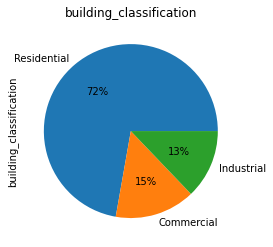

In [ ]:
df_cambridge[TARGET_COL].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title(TARGET_COL)

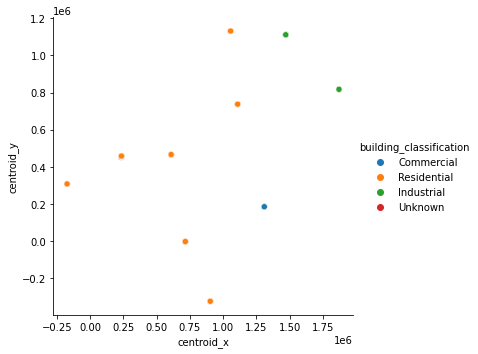

In [ ]:
#Cambridge Bay
sns.relplot(x='centroid_x', y='centroid_y', data=df, kind="scatter",hue=TARGET_COL)

Summary statistics for numerical columns

## Pre-Processing

In [ ]:
# Get the newest dataset
df = get_most_updated_dataset() 


df_original = df # TODO: change to shallow or deep copy this could cause problems
df = df.fillna(0)

# Keep important features (columns)
X = df[FEATURE_COLS]
Y = df_original[TARGET_COL]

#df[TARGET_COL].value_counts()
df

building_footprints_dataset_14_08_2021_13_48.csv


,centroid_x,centroid_y,area,perimeter,perimeter_index,detour,width,length,pnt_count,exchange,exchange_index,range,range_index,min,max,building_classification,community_name,fractal_dimensions,building_height,height_area,volume,length_width,building_type
osm_way_id,,,,,,,,,,,,,,,,,,,,,,,
146311312.0,236375.9673,458215.5240,1358.082946,154.165029,1.181596,147.327370,44.596852,51.813265,9.0,1159.061592,0.853454,52.467245,1.585112,15.801981,27.640675,Commercial,cambridge bay,8.809280,11.838694,0.008717,16077.927908,1.161814,Commercial
146311316.0,236330.6174,458523.3054,463.591172,87.969683,1.154016,87.969683,29.283676,22.137738,5.0,383.796205,0.827876,31.669104,1.534323,16.852879,21.869761,Residential,cambridge bay,5.269897,5.016882,0.010822,2325.782178,0.755975,Multi-Unit Residential
146311319.0,236243.3362,458305.5581,1221.919762,149.322080,1.206561,149.322080,42.425538,56.388607,8.0,889.510048,0.727961,56.263942,1.402091,15.352618,23.766201,Commercial,cambridge bay,8.183115,8.413583,0.006886,10280.723093,1.329119,Commercial
146311320.0,236753.9965,458352.1783,115.094977,44.710700,1.177144,44.710700,16.198747,12.276077,5.0,89.339732,0.776226,16.412462,1.475161,10.602724,13.283726,Residential,cambridge bay,2.574216,2.681002,0.023294,308.569824,0.757841,Single-Unit Residential
146311322.0,235993.5425,458208.1908,669.116281,151.280944,1.651885,145.292670,61.574825,18.019949,7.0,293.772362,0.439045,61.846853,0.943883,8.738390,17.486572,Commercial,cambridge bay,4.423004,8.748182,0.013074,5853.551207,0.292651,Commercial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905192470.0,609407.2785,466556.6204,423.804552,98.991302,1.358190,98.991302,39.904063,17.730913,5.0,245.368193,0.578965,40.025919,1.160718,30.069035,31.984863,Residential,gjoa haven,4.281230,1.915829,0.004521,811.936924,0.444339,0
905192474.0,609335.5637,466370.9443,425.965472,104.117947,1.424901,104.117947,43.013096,17.090220,5.0,228.422054,0.536245,43.004907,1.083064,25.452986,29.883318,Residential,gjoa haven,4.091182,4.430332,0.010401,1887.168542,0.397326,0
905192475.0,609230.6814,466537.9144,472.433857,102.343853,1.329957,102.343853,39.676267,13.106080,5.0,283.386715,0.599844,41.060078,1.194637,33.004990,35.847733,Residential,gjoa haven,4.616143,2.842743,0.006017,1343.008002,0.330325,0


### Integer Encode Target Column

In [ ]:
# Create a dict for target classes
target_col_keys = df[TARGET_COL].unique()
target_dict = dict(zip(sorted(target_col_keys), range(len(target_col_keys)) ))

In [ ]:
# helper functions
def convert_target_col(value):
  ''' Converts string to numeric value {0:len(target_col_keys)}
  value (string): building type or class'''
  result = value
  if value in target_dict:
      result = target_dict[value]
  return result

# Verbose testing
print(target_dict, "\n")
print(df[TARGET_COL].head(), "\n")

# Drop the rows with `Unknown`
# df.drop(df[df[TARGET_COL] == 'Unknown'].index, inplace=True)

df[TARGET_COL] = df[TARGET_COL].apply(convert_target_col)

# to test
df[TARGET_COL].head()

{'Commercial': 0, 'Industrial': 1, 'Residential': 2, 'Unknown': 3} 

osm_way_id
146311312.0     Commercial
146311316.0    Residential
146311319.0     Commercial
146311320.0    Residential
146311322.0     Commercial
Name: building_classification, dtype: object 



osm_way_id
146311312.0    0
146311316.0    2
146311319.0    0
146311320.0    2
146311322.0    0
Name: building_classification, dtype: int64

## Transform Module

In [ ]:
# Set the constants module filename
_remote_communities_constants_module_file = 'remote_communities_constants.py'

In [ ]:
%%writefile {_remote_communities_constants_module_file}

# Target column (Y)
TARGET_COL = 'building_type' 

# columns (numeric) of interest
FEATURE_COLS = [ "shape_area", 'perimeter', 'centroid_x', \
         'centroid_y', 'pnt_count', 'min', 'max', 'building_h']

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Overwriting remote_communities_constants.py


In [ ]:
# Set the transform module filename
_remote_communities_transform_module_file = 'remote_communities_transform.py'

In [ ]:
%%writefile {_remote_communities_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import remote_communities_constants
import tensorflow_addons as tfa

import math as m

# Unpack the contents of the constants module
_FEATURE_COLS = remote_communities_constants.FEATURE_COLS
_transformed_name = remote_communities_constants.transformed_name

# define the transformations
def preprocessing_fn(inputs):
    """Preprocess input columns into transformed columns."""

    outputs = inputs.copy()

    # Filter redundant features
    # for key in : 
    #     if key is not in (_FEATURE_COLS + [remote_communities_constants.TARGET_COL])
    #         del outputs[key]
    
    # Feature Engineering
    # df['shape_index'] = df['perimeter'] 
    outputs['fractal_dimensions'] = outputs['shape_area'] / outputs['perimeter']
    outputs['height_area'] = outputs['building_h'] / outputs['shape_area']
    outputs['volume'] = outputs['building_h'] * outputs['shape_area']

    if 'width' in _FEATURE_COLS and 'length' in _FEATURE_COLS:
        outputs['length_width'] = outputs['length'] / outputs['width'] 

    
    
    # Scale selected numeric features
    for key in _FEATURE_COLS:
        outputs[key] = tft.scale_to_0_1(outputs[key])

    return outputs


Overwriting remote_communities_transform.py


Run the `Transform` component below to perform the transformations.

In [ ]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_remote_communities_transform_module_file))

# Run the component
context.run(transform)

NameError: ignored

## Modeling, Feature Selection, Hypertuning Parameters 

### Random Forest Model

The following code performs a stratefied split of the data into test and training sets and then uses a random forest model to classify the buildings.

#### Functions for Visualizations


In [ ]:
def display_confusion_matrix(y_pred, y_test):
  # Get and reshape confusion matrix data
  labels = ['Commercial', 'Industrial', 'Residential']
  matrix = metrics.confusion_matrix(y_test, y_pred, labels = [0,1,2])
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
  # Build the plot
  plt.figure(figsize=(16,4))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size':10},
              cmap=plt.cm.Greens, linewidths=0.2)

  # Add labels to the plot
  class_names = labels
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=25)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix for Random Forest Model')
  plt.show()

def visualize_stratified_datasets(X_train, X_test, y_train, y_test): 
    
    transdict = { 0 : 'Commercial',
              1: 'Industrial',
              2: 'Residential',
              3: 'Unknown'
    }
    #Y_trans = [transdict[i] for i in Y]
    Y_trans = Y

    y_train_trans = pd.Series([transdict[i] for i in np.array(y_train)])
    y_test_trans = pd.Series([transdict[i] for i in np.array(y_test)])
    
    print("{} examples in training, {} examples for testing.".format(
        len(y_train), len(y_test)), "\n")

    print('-------------------------------------------------------')
    # Print actual value count

    print(f"Value counts for each class:\n\n{Y_trans.value_counts()}\n")

    # Display pie chart to visually check the proportion
    Y.value_counts().plot.pie(y='label',ylabel = '',labels=['Residential','Commercial','Industrial', 'Unknown'],title='Proportion for entire dataset', autopct='%1.1f%%',  figsize=(11,6))
    plt.show()

    # Compare train and test % to check if balanced datasets
    # Print actual value count
    print(f"Value counts for each class:\n\n{y_train_trans.value_counts()}\n")

    # Display pie chart to visually check the proportion
    y_train.value_counts().plot.pie(y='label', ylabel = '',labels=['Residential','Commercial','Industrial', 'Unknown'],title='Proportion for train dataset', autopct='%1.1f%%',  figsize=(11,6))
    plt.show()

    # Compare train and test % to check if balanced datasets
    # Print actual value count
    print(f"Value counts for each class:\n\n{y_test_trans.value_counts()}\n")

    # Display pie chart to visually check the proportion
    y_test.value_counts().plot.pie(y='label',ylabel = '', labels=['Residential','Commercial','Industrial', 'Unknown'], title='Proportion for test dataset', autopct='%1.1f%%',  figsize=(11,6))
    plt.show()

#### Functions for the Random Forest Model

In [ ]:
def balance_training_set(X_train, y_train):
  '''Balance training set by oversampling'''
  
  over_sampler = RandomOverSampler(random_state=42)
  X_res, y_res = over_sampler.fit_resample(X_train, y_train)
  X_train = X_res
  y_train = pd.Series(y_res)
  
  return X_train, y_train
  
def create_training_set(community):
  '''Create training set from data excluding community'''

  #put all !cambridge bay data in training set
  df_train = df.loc[df['community_name'] != community]
  X_train = df_train[FEATURE_COLS]
  y_train = df_train[TARGET_COL]  
  
  return X_train, y_train

def create_test_set(community):
  '''Create test set of community data'''

  #put cambridge bay data into test set
  df_test = df.loc[df['community_name'] == community]
  X_test = df_test[FEATURE_COLS]
  y_test = df_test[TARGET_COL]  

  return X_test, y_test

def train_test_split_manual(community):
  '''Create test set from community and training set from complement'''

  X_train, y_train = create_training_set(community) #create train
  if BALANCE_TRAINSET:
      X_train, y_train = balance_training_set(X_train, y_train) #balance train
  X_test, y_test = create_test_set(community) #create test
  return X_train, X_test, y_train, y_test 

def fit_model(X_train, y_train):
  '''Train a Random Forest Classifier'''

  model=RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=2)
  model = model.fit(X_train,y_train) #Train the model using the training sets
  estimator = model.estimators_[3] # Extract single tree for visualization

  return model

def evaluate_model_on_features(community):
  '''Train model and display evaluation metrics.'''

  X_train, X_test, y_train, y_test = train_test_split_manual(community) #split data
  model = fit_model(X_train, y_train) #train model
  y_pred = model.predict(X_test) #fit model

  # Remove data labelled as 'Unknown' from accuracy metrics
  drop_indices = y_test[y_test==3].index
  y_test_new = y_test.drop(drop_indices)
  X_test_new = X_test.drop(drop_indices)
  y_pred_new = []
  for t,p in zip(y_test, y_pred):
    if t != target_dict['Unknown']:
      y_pred_new.append(p)

  
  # Calculate evaluation metrics for assesing performance of the model.
  roc = metrics.roc_auc_score(y_test_new, model.predict_proba(X_test_new), average='weighted', multi_class='ovr')
  acc = metrics.accuracy_score(y_test_new, y_pred_new)
  prec = metrics.precision_score(y_test_new, y_pred_new, average='weighted')
  rec = metrics.recall_score(y_test_new, y_pred_new, average='weighted')
  f1 = metrics.f1_score(y_test_new, y_pred_new, average='weighted')
  
  print('\033[1m' + "Accuracy:", acc)
  print('\033[1m' + "ROC:", roc)
  print('\033[1m' + "Precision:", prec)
  print('\033[1m' + "Recall:", rec)
  print('\033[1m' + "F1 Score:", f1)
  print("Using Features:" + '\033[0m', FEATURE_COLS, '\n\n\n')
  
  display_confusion_matrix(y_pred_new, y_test_new)

  #visualizing dataset
  visualize_stratified_datasets(X_train, X_test, y_train, y_test_new)
  return y_test, y_pred, roc, acc, prec, rec, f1


#### Running the Model & Displaying Metrics

Accuracy: 0.7586805555555556
ROC: 0.8322334695726731
Precision: 0.7512298264299005
Recall: 0.7586805555555556
F1 Score: 0.7528914584206386
Using Features: ['area', 'perimeter', 'perimeter_index', 'detour', 'width', 'length', 'exchange', 'exchange_index', 'range', 'range_index', 'pnt_count', 'fractal_dimensions', 'height_area', 'volume', 'building_height'] 





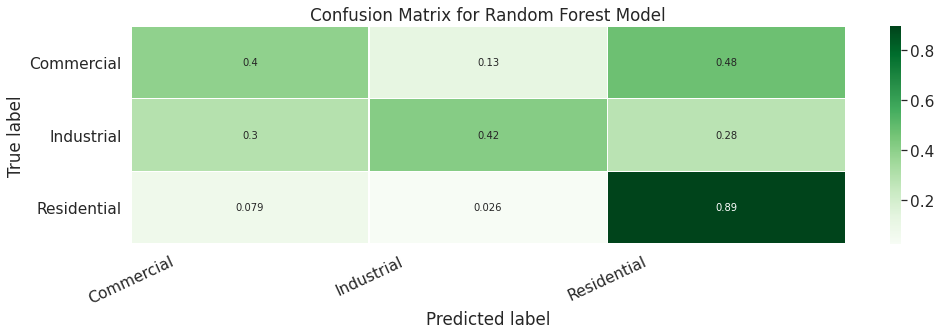

611 examples in training, 576 examples for testing. 

-------------------------------------------------------
Value counts for each class:

Residential    804
Commercial     194
Industrial     189
Unknown        110
Name: building_classification, dtype: int64



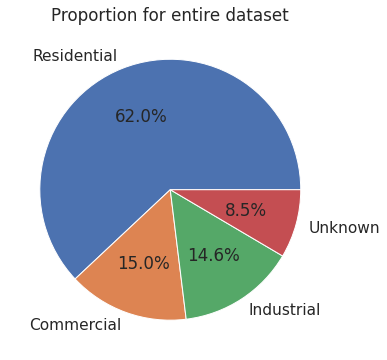

Value counts for each class:

Residential    388
Industrial     115
Commercial     108
dtype: int64



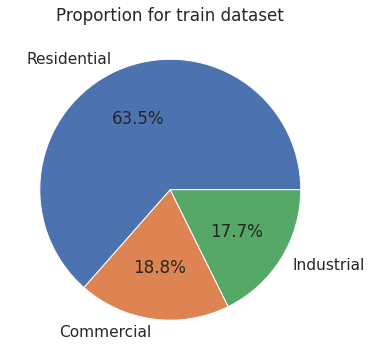

Value counts for each class:

Residential    416
Commercial      86
Industrial      74
dtype: int64



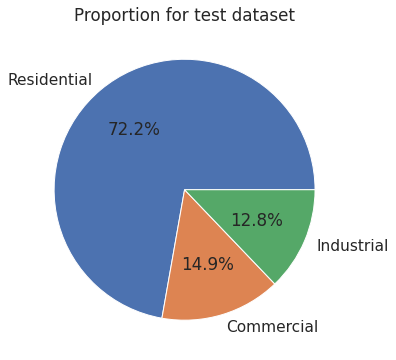

In [ ]:
y_test, y_pred, roc, acc, prec, rec, f1 = evaluate_model_on_features('cambridge bay')

 #### Visualizing the Model

In [ ]:
# Export as dot file
model=RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=2)
model = model.fit(X_train,y_train) #Train the model using the training sets
estimator = model.estimators_[3]

export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['Commercial', 'Industrial', 'Residential'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

NameError: ignored

##### Display tree

In [ ]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

### Feature Selection

#### Correlated Features

You may want to drop redundant features to reduce the complexity of your model. Let's see what features are highly correlated with each other by plotting the correlation matrix.

In [ ]:
def show_correlation_heatmap(dataframe):
    plt.figure(figsize=(20,20))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
    plt.show()

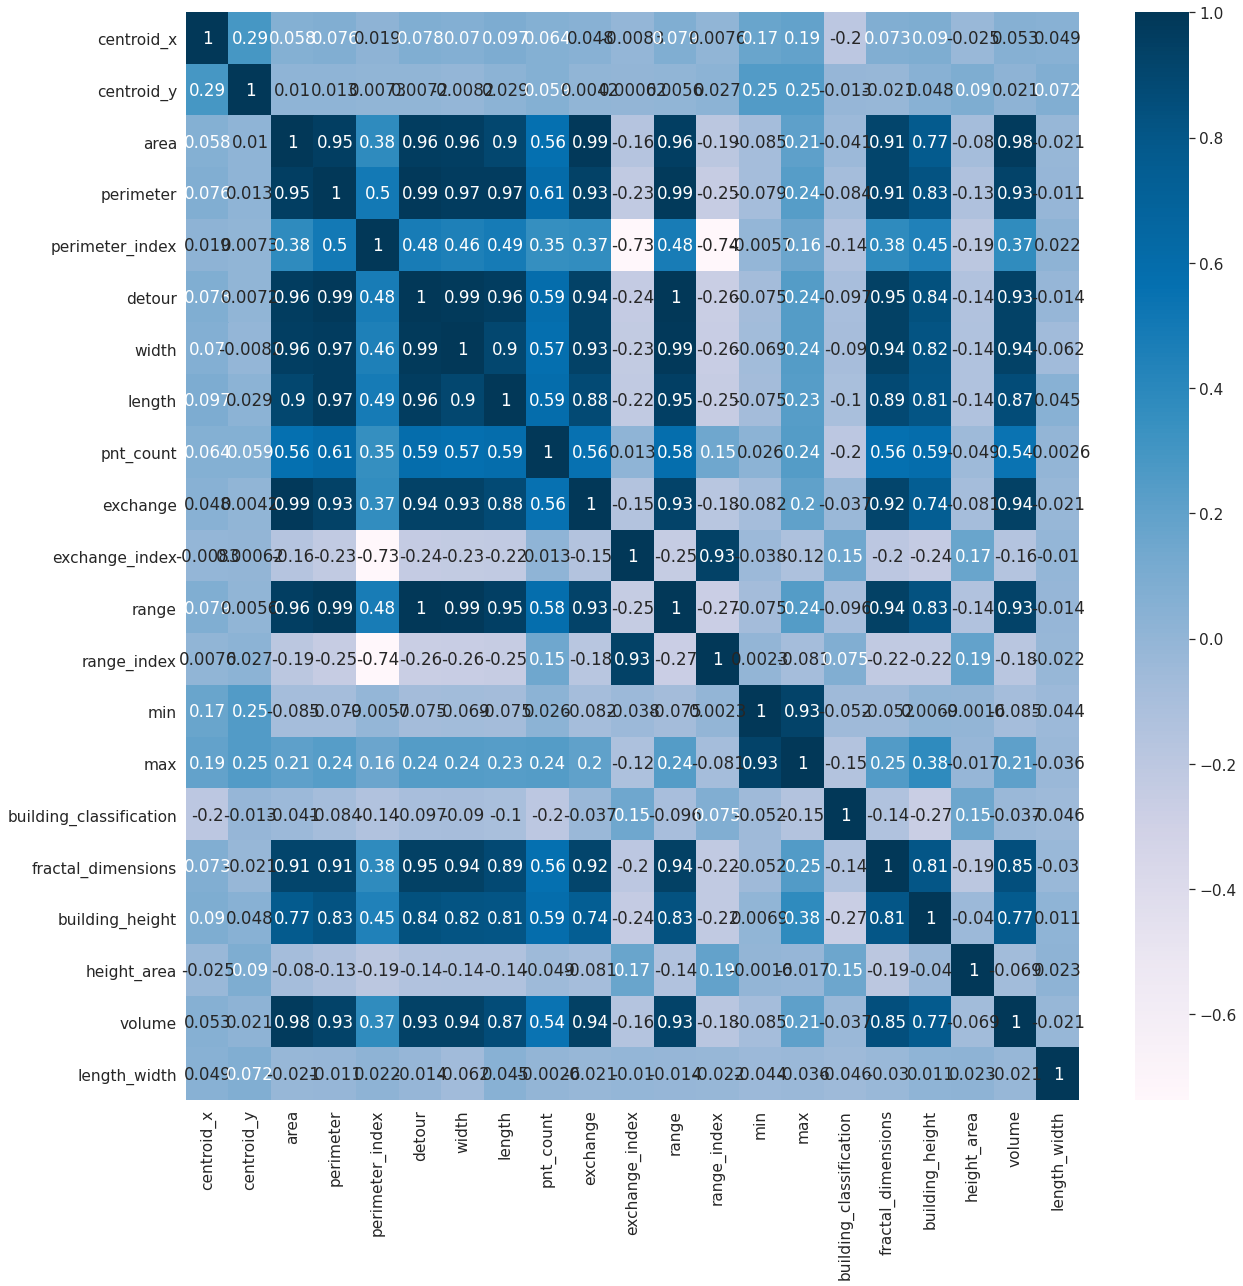

In [ ]:
show_correlation_heatmap(df)

Above heatmap is just for inference for now.

#### Feature Importance 

In [ ]:
def feature_importances_from_tree_based_model_(X_test, X_train):
    
    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,y_train)
    
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()
    return model

def select_features_from_model(model):
    
   mod = SelectFromModel(model, prefit=True , threshold=0.055) #can change the threshold
   X_new = mod.transform(X)
   feature_idx = mod.get_support()
   feature_names = X.columns[feature_idx]
   return feature_names

Show the feature importance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


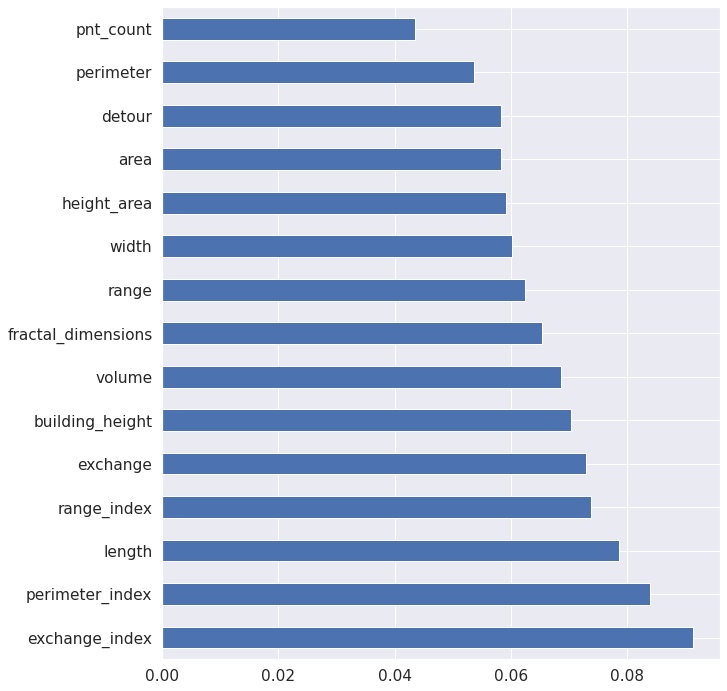

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_manual('cambridge bay')
model = feature_importances_from_tree_based_model_(X_test, X_train)

**Running the model with feature selection**

Accuracy: 0.7586805555555556
ROC: 0.8224607959001577
Precision: 0.7534593323021397
Recall: 0.7586805555555556
F1 Score: 0.754383965371016
Using Features: Index(['area', 'perimeter_index', 'detour', 'width', 'length', 'exchange',
       'exchange_index', 'range', 'range_index', 'fractal_dimensions',
       'height_area', 'volume', 'building_height'],
      dtype='object') 





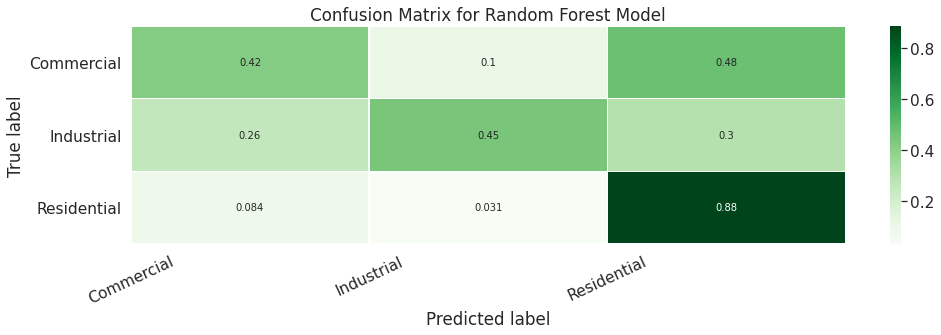

611 examples in training, 576 examples for testing. 

-------------------------------------------------------
Value counts for each class:

Residential    804
Commercial     194
Industrial     189
Unknown        110
Name: building_classification, dtype: int64



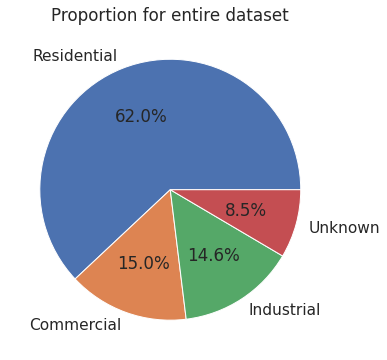

Value counts for each class:

Residential    388
Industrial     115
Commercial     108
dtype: int64



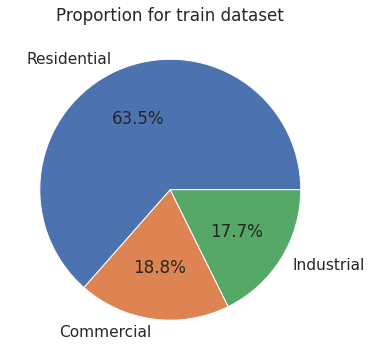

Value counts for each class:

Residential    416
Commercial      86
Industrial      74
dtype: int64



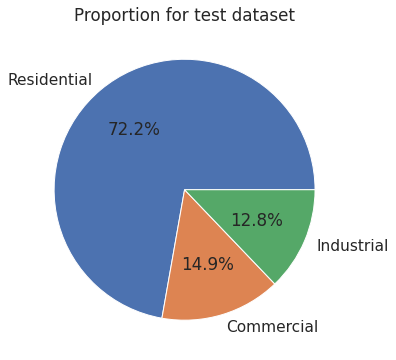

In [ ]:
# update global variable FEATURE_COLS
feature_importance = select_features_from_model(model)
FEATURE_COLS = feature_importance

y_test, y_pred, roc_fi, acc_fi, prec_fi, rec_fi, f1_fi = evaluate_model_on_features('cambridge bay')

# Convert back to original user supplied features
FEATURE_COLS = FEATURE_COLS_ORIGINAL


#### univariate_selection

The important features for univariate_selection method are: 
<function univariate_selection at 0x7f67f23aca70>
Accuracy: 0.7430555555555556
ROC: 0.8370261328199108
Precision: 0.7482183496091902
Recall: 0.7430555555555556
F1 Score: 0.7441057488634885
Using Features: Index(['detour', 'width', 'length', 'exchange_index', 'range', 'range_index',
       'pnt_count', 'fractal_dimensions', 'building_height'],
      dtype='object') 





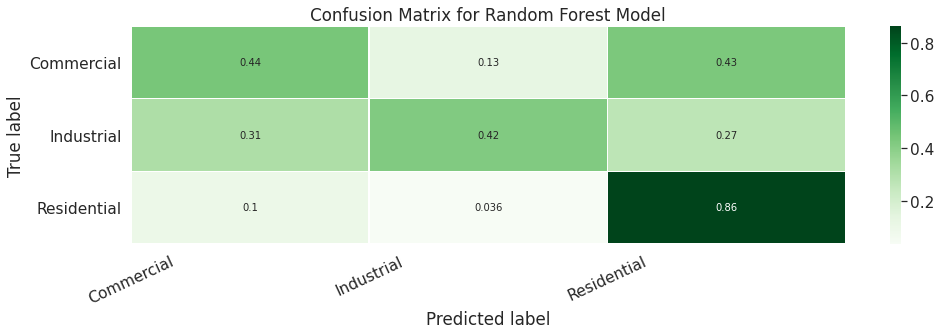

611 examples in training, 576 examples for testing. 

-------------------------------------------------------
Value counts for each class:

Residential    804
Commercial     194
Industrial     189
Unknown        110
Name: building_classification, dtype: int64



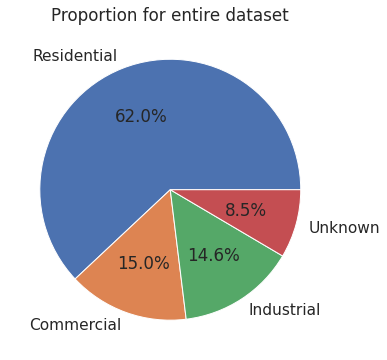

Value counts for each class:

Residential    388
Industrial     115
Commercial     108
dtype: int64



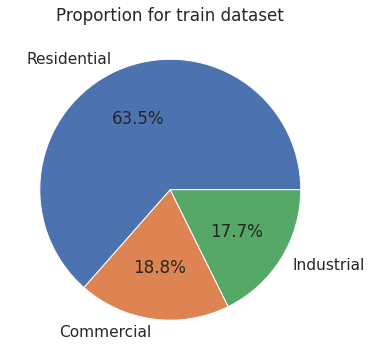

Value counts for each class:

Residential    416
Commercial      86
Industrial      74
dtype: int64



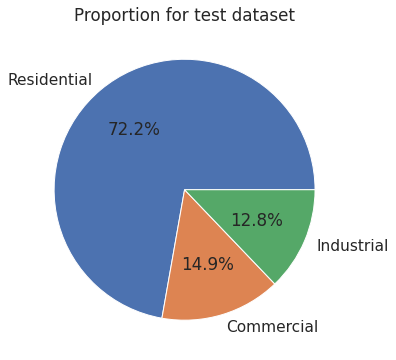

In [ ]:
def univariate_selection(X_train, X_test, Y_train, Y_test):
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # User SelectKBest to select top 9 features based on f-test
    selector = SelectKBest(f_classif, k=9)
    
    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)
    
    # Get boolean list of important features
    feature_idx = selector.get_support()
        
    # Drop the 
    feature_names = X.columns[feature_idx]
    
    return feature_names

X_train, X_test, y_train, y_test = train_test_split_manual('cambridge bay')

print('The important features for univariate_selection method are: ')
univariate_feature_names = univariate_selection(X_train, X_test, y_train, y_test)
print(univariate_selection)

# update global variable FEATURE_COLS

FEATURE_COLS = univariate_feature_names

y_test, y_pred, roc_uni, acc_uni, prec_uni, rec_uni, f1_uni = evaluate_model_on_features('cambridge bay')

# Convert back to original user supplied features
FEATURE_COLS = FEATURE_COLS_ORIGINAL

#### L1 Regularization
L1 or Lasso Regulartization introduces a penalty term to the loss function which leads to the least important features being eliminated. Implementation in scikit-learn can be done with a LinearSVC model as the learning algorithm. You can then use SelectFromModel to select features based on the LinearSVC model’s output of L1 regularization.

In [1]:
def run_l1_regularization(X_train, X_test, Y_train, Y_test):
    
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select L1 regulated features from LinearSVC output 
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)
     
    feature_names = X.columns[(selection.get_support())]
    
   
    return feature_names

X_train, X_test, Y_train, Y_test = train_test_split_manual('cambridge bay')



# update global variable FEATURE_COLS
l1reg_feature_names = run_l1_regularization(X_train, X_test, Y_train, Y_test)
FEATURE_COLS = l1reg_feature_names

y_test, y_pred, roc_l1, acc_l1, prec_l1, rec_l1, f1_l1 = evaluate_model_on_features('cambridge bay')

# Convert back to original user supplied features
FEATURE_COLS = FEATURE_COLS_ORIGINAL


NameError: ignored

#### Comparing Feature Selection Methods:

In [ ]:
print("Feature Importance Method: ", feature_importance, '\n\nROC:', roc_fi, '\nACC', acc_fi, '\nPRECISION:', prec_fi,'\nRECALL', rec_fi, '\nF1 SCORE', f1_fi, '\n')

print("Univariate Method: \n", univariate_feature_names, '\n\nROC:', roc_uni, '\nACC', acc_uni, '\nPRECISION:', prec_uni,'\nRECALL', rec_uni, '\nF1 SCORE', f1_uni, '\n')
print("L1 Regularization: \n", l1reg_feature_names, '\n\nROC:', roc_l1, '\nACC', acc_l1, '\nPRECISION:', prec_l1,'\nRECALL', rec_l1, '\nF1 SCORE', f1_l1, '\n')

Choose Best Feature Selection Method and features

In [ ]:
# If Feature Importance is the best
if f1_fi < f1_uni and f1_fi < f1_l1:
    FEATURE_COLS = feature_importance

# If Univariance feature selection is the best
elif f1_uni < f1_fi and f1_uni < f1_l1:
    FEATURE_COLS = univariate_feature_names

# If L1 Regularization is the best
else: # f1_l1 < f1_fi and f1_l1 < f1_uni:
    FEATURE_COLS = l1reg_feature_names

### Hypertuning Parameters 

**Using a Random Hyperparameter Grid**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def random_hyperparameter_grid():

  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(5, 110, num = 22)]
  max_depth.append(None)

  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
 
  # Method of selecting samples for training each tree
  random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split}

  return random_grid

def random_search_training(X_train,y_train, random_grid):
  '''Use the random grid to search for best hyperparameters'''
  # create the base model to tune
  rf = RandomForestRegressor()
  # Random search of parameters, using 3 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  # Fit the random search model
  rf_random.fit(X_train, y_train)
  rf_random.best_params_
  return rf_random

def evaluate(model, test_features, test_labels):

    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * (errors / test_labels)
    accuracy = 100 - np.mean(mape[np.isfinite(mape)])
    print('Model Performance')
    print('Average Error:',(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy


def train_hypertune(X_train, y_train):
  random_grid = random_hyperparameter_grid()
  rf_random = random_search_training(X_train,y_train,random_grid)
  return rf_random

def evaluate_hypertune_and_display_metrics(X_train, X_test, y_train, y_test):
  base_model = RandomForestRegressor()
  base_model.fit(X_train, y_train)
  print('Base Model Performance')
  base_accuracy = evaluate(base_model, X_test, y_test)
  best_random = rf_random.best_estimator_
  print('Hypertuned Model Performance')
  random_accuracy = evaluate(best_random, X_test, y_test)

  print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
  if random_accuracy > base_accuracy:
    return best_random
  else:
    return base_model

Training Hypertuner 

Note: This usually takes 10+ minutes to run

In [ ]:
rf_random = train_hypertune(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.1min finished


Evaluate Model

In [ ]:
best_model = evaluate_hypertune_and_display_metrics(X_train, X_test, y_train, y_test)

Base Model Performance
Model Performance
Average Error: 0.7036151603498539
Accuracy = 70.15%.
Hypertuned Model Performance
Model Performance
Average Error: 0.6598937873224296
Accuracy = 72.65%.
Improvement of 3.56%.


**Using Grid Search with Cross Validation**

In [ ]:
from sklearn.model_selection import GridSearchCV

def create_grid():
  # Create the parameter grid based on the results of random search 
  param_grid = {
      'max_depth': [80, 90, 100, 110],
      'min_samples_split': [8, 10, 12],
      'n_estimators': [100, 200, 300, 1000]
  }
  # Create a based model
  rf = RandomForestRegressor()
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 3, n_jobs = -1, verbose = 2)
  return grid_search

def evaluate_grid_search(grid_search, train_features, test_features, train_labels, test_labels):
  # Fit the grid search to the data
  grid_result = grid_search.fit(train_features, train_labels)
  grid_search.best_params_

  best_grid = grid_search.best_estimator_
  grid_accuracy = evaluate(best_grid, test_features, test_labels)

  base_model = RandomForestRegressor()
  base_model.fit(X_train, y_train)
  base_accuracy = evaluate(base_model, X_test, y_test)

  print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

def create_grid_and_evaluate(X_train, X_test, y_train, y_test):
  grid_search = create_grid()
  evaluate_grid_search(grid_search, X_train, X_test, y_train, y_test)


Run the grid search

In [ ]:
create_grid_and_evaluate(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.6min finished


Model Performance
Average Error: 0.7924646248859191
Accuracy = 64.94%.
Model Performance
Average Error: 0.7994752186588913
Accuracy = 64.58%.
Improvement of 0.57%.
Best: 0.596028 using {'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 200}
0.589150 (0.235576) with: {'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}
0.596028 (0.226374) with: {'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 200}
0.589220 (0.225591) with: {'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}
0.589819 (0.233094) with: {'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 1000}
0.565182 (0.222748) with: {'max_depth': 80, 'min_samples_split': 10, 'n_estimators': 100}
0.568227 (0.222277) with: {'max_depth': 80, 'min_samples_split': 10, 'n_estimators': 200}
0.569952 (0.222149) with: {'max_depth': 80, 'min_samples_split': 10, 'n_estimators': 300}
0.574027 (0.221009) with: {'max_depth': 80, 'min_samples_split': 10, 'n_estimators': 1000}
0.559129 (0.200293) with: {'max_de

**Comparisons of all models**

In [ ]:
# from tabulate import tabulate
# table = [['Model', 'Accuracy', 'Average Error','n_estimators', 'min_samples_split','max_depth'],['Base model', '70.65 %', '0.525845','100', '2', '7'], ['Best model (Random search)', '80.58 %','0.447929','1200', '10', '10'], ['Best model (grid search)', '76.06 %','0.483165','200', '12', '90']]
# print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', showindex=False))
# print('Improvement of 0.14 % for random accuracy. ')
# print('Improvement of 7.66% % for grid accuracy. ')

## Post Model: Results, Inference and Output

The following code appends the classifications made by the random forest model to the dataframe and creates 'output.csv' with the updated data. 

In [ ]:
#TABLE OF CORRECT/INCORRECT CLASSIFICATIONS


#make predictions on entire cambridge bay dataset (including buildings labelled as unknown)
#then append column to database

#Put back string values 
model = RandomForestClassifier()
model = model.fit(X_train,y_train)
test = np.array(y_test)
pred = np.array(model.predict(X_test))

indices = np.array(y_test.index)
osm_way_id = []
status = []

transdict = { 0 : 'Commercial',
              1: 'Industrial',
              2: 'Residential',
              3: 'Unknown'
}
def convert_target_cal_back(row):
  row[TARGET_COL] = transdict[row[TARGET_COL]]
  return row

df = df.apply(convert_target_cal_back, axis=1)

test = [transdict[i] for i in test]
pred = [transdict[i] for i in pred]

zipped_data = zip(indices, test, pred)


for id, t, p in zip(indices, test, pred):
  osm_way_id.append(id)
  if t == 'Unknown':
    status.append("N/A")
  elif t != p:
    status.append("Incorrect")
  else :
    status.append("Correct")

classifications = pd.DataFrame({"osm_way_id":osm_way_id, "predicted": pred, "actual": test, "status":status})
classifications = classifications.set_index("osm_way_id")

df_merged = df.join(classifications, how='outer', lsuffix='', rsuffix='_old')

drop_cols = [col for col in df_merged.columns if col.endswith('_old') ]
cols = df_merged.columns
df_merged = df_merged.apply(combine_func, axis='columns')
   
df_merged.drop(drop_cols, axis='columns', inplace=True)
df_merged


,centroid_x,centroid_y,area,perimeter,perimeter_index,detour,width,length,pnt_count,exchange,exchange_index,range,range_index,min,max,building_classification,community_name,fractal_dimensions,building_height,height_area,volume,length_width,building_type,predicted,actual,status
osm_way_id,,,,,,,,,,,,,,,,,,,,,,,,,,
146311312.0,236375.9673,458215.5240,1358.082946,154.165029,1.181596,147.327370,44.596852,51.813265,9.0,1159.061592,0.853454,52.467245,1.585112,15.801981,27.640675,Commercial,cambridge bay,8.809280,11.838694,0.008717,16077.927908,1.161814,Commercial,Commercial,Commercial,Correct
146311316.0,236330.6174,458523.3054,463.591172,87.969683,1.154016,87.969683,29.283676,22.137738,5.0,383.796205,0.827876,31.669104,1.534323,16.852879,21.869761,Residential,cambridge bay,5.269897,5.016882,0.010822,2325.782178,0.755975,Multi-Unit Residential,Industrial,Residential,Incorrect
146311319.0,236243.3362,458305.5581,1221.919762,149.322080,1.206561,149.322080,42.425538,56.388607,8.0,889.510048,0.727961,56.263942,1.402091,15.352618,23.766201,Commercial,cambridge bay,8.183115,8.413583,0.006886,10280.723093,1.329119,Commercial,Commercial,Commercial,Correct
146311320.0,236753.9965,458352.1783,115.094977,44.710700,1.177144,44.710700,16.198747,12.276077,5.0,89.339732,0.776226,16.412462,1.475161,10.602724,13.283726,Residential,cambridge bay,2.574216,2.681002,0.023294,308.569824,0.757841,Single-Unit Residential,Residential,Residential,Correct
146311322.0,235993.5425,458208.1908,669.116281,151.280944,1.651885,145.292670,61.574825,18.019949,7.0,293.772362,0.439045,61.846853,0.943883,8.738390,17.486572,Commercial,cambridge bay,4.423004,8.748182,0.013074,5853.551207,0.292651,Commercial,Residential,Commercial,Incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905192470.0,609407.2785,466556.6204,423.804552,98.991302,1.358190,98.991302,39.904063,17.730913,5.0,245.368193,0.578965,40.025919,1.160718,30.069035,31.984863,Residential,gjoa haven,4.281230,1.915829,0.004521,811.936924,0.444339,0,NaN,NaN,NaN
905192474.0,609335.5637,466370.9443,425.965472,104.117947,1.424901,104.117947,43.013096,17.090220,5.0,228.422054,0.536245,43.004907,1.083064,25.452986,29.883318,Residential,gjoa haven,4.091182,4.430332,0.010401,1887.168542,0.397326,0,NaN,NaN,NaN
905192475.0,609230.6814,466537.9144,472.433857,102.343853,1.329957,102.343853,39.676267,13.106080,5.0,283.386715,0.599844,41.060078,1.194637,33.004990,35.847733,Residential,gjoa haven,4.616143,2.842743,0.006017,1343.008002,0.330325,0,NaN,NaN,NaN


In [ ]:
df_merged.columns

Index(['centroid_x', 'centroid_y', 'area', 'perimeter', 'perimeter_index',
       'detour', 'width', 'length', 'pnt_count', 'exchange', 'exchange_index',
       'range', 'range_index', 'min', 'max', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_height',
       'height_area', 'volume', 'length_width', 'building_type', 'predicted',
       'actual', 'status'],
      dtype='object')

Making this the most updated dataset

In [ ]:
#append to csv
df_merged.to_csv("output.csv", index=True)
!cp output.csv "./pipeline/data/processed"

df_merged

,centroid_x,centroid_y,area,perimeter,perimeter_index,detour,width,length,pnt_count,exchange,exchange_index,range,range_index,min,max,building_classification,community_name,fractal_dimensions,building_height,height_area,volume,length_width,building_type,predicted,actual,status
osm_way_id,,,,,,,,,,,,,,,,,,,,,,,,,,
146311312.0,236375.9673,458215.5240,1358.082946,154.165029,1.181596,147.327370,44.596852,51.813265,9.0,1159.061592,0.853454,52.467245,1.585112,15.801981,27.640675,Commercial,cambridge bay,8.809280,11.838694,0.008717,16077.927908,1.161814,Commercial,Commercial,Commercial,Correct
146311316.0,236330.6174,458523.3054,463.591172,87.969683,1.154016,87.969683,29.283676,22.137738,5.0,383.796205,0.827876,31.669104,1.534323,16.852879,21.869761,Residential,cambridge bay,5.269897,5.016882,0.010822,2325.782178,0.755975,Multi-Unit Residential,Industrial,Residential,Incorrect
146311319.0,236243.3362,458305.5581,1221.919762,149.322080,1.206561,149.322080,42.425538,56.388607,8.0,889.510048,0.727961,56.263942,1.402091,15.352618,23.766201,Commercial,cambridge bay,8.183115,8.413583,0.006886,10280.723093,1.329119,Commercial,Commercial,Commercial,Correct
146311320.0,236753.9965,458352.1783,115.094977,44.710700,1.177144,44.710700,16.198747,12.276077,5.0,89.339732,0.776226,16.412462,1.475161,10.602724,13.283726,Residential,cambridge bay,2.574216,2.681002,0.023294,308.569824,0.757841,Single-Unit Residential,Residential,Residential,Correct
146311322.0,235993.5425,458208.1908,669.116281,151.280944,1.651885,145.292670,61.574825,18.019949,7.0,293.772362,0.439045,61.846853,0.943883,8.738390,17.486572,Commercial,cambridge bay,4.423004,8.748182,0.013074,5853.551207,0.292651,Commercial,Residential,Commercial,Incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905192470.0,609407.2785,466556.6204,423.804552,98.991302,1.358190,98.991302,39.904063,17.730913,5.0,245.368193,0.578965,40.025919,1.160718,30.069035,31.984863,Residential,gjoa haven,4.281230,1.915829,0.004521,811.936924,0.444339,0,NaN,NaN,NaN
905192474.0,609335.5637,466370.9443,425.965472,104.117947,1.424901,104.117947,43.013096,17.090220,5.0,228.422054,0.536245,43.004907,1.083064,25.452986,29.883318,Residential,gjoa haven,4.091182,4.430332,0.010401,1887.168542,0.397326,0,NaN,NaN,NaN
905192475.0,609230.6814,466537.9144,472.433857,102.343853,1.329957,102.343853,39.676267,13.106080,5.0,283.386715,0.599844,41.060078,1.194637,33.004990,35.847733,Residential,gjoa haven,4.616143,2.842743,0.006017,1343.008002,0.330325,0,NaN,NaN,NaN


### Building Visualizations

In [ ]:
#dataset
print("dataset: ", df.shape)

#Tree classification results
trees = pd.read_csv(os.path.join(data_path_processed, 'output.csv'))
trees=trees[trees['community_name']=="cambridge bay"]
trees=trees[trees['building_classification']!="Unknown"]
print("tree classification : ",trees.shape)
print(trees.columns)

dataset:  (1540, 27)
tree classification :  (576, 24)
Index(['osm_way_id', 'centroid_x', 'centroid_y', 'area', 'perimeter',
       'perimeter_index', 'detour', 'width', 'lengh', 'pnt_count', 'exchange',
       'exchange_index', 'range', 'range_index', 'building_classification',
       'community_name', 'fractal_dimensions', 'building_type', 'building_h',
       'height_area', 'volume', 'predicted', 'actual', 'status'],
      dtype='object')


View correctly vs incorrectly predicted for Cambridge Bay per each response variable

In [ ]:
#Crossvalidation
print(target_dict)
pd.crosstab(df_merged[TARGET_COL], df_merged['status'])

{'Commercial': 0, 'Industrial': 1, 'Residential': 2, 'Unknown': 3}


status,Correct,Incorrect,N/A
building_classification,,,
0,38,48,0
1,33,41,0
2,335,81,0
3,0,0,110


#### Convert CSV to GIS datasets (TODO) 
May have to do this in QGIS

IDEAS: 
1. Create one large shp file
2. Groupby `community_name` then create shp

NOTE: If done in notebook, you need every vertex of each polygon